In [30]:
import pandas as pd
import numpy as np
import subprocess
import seaborn as sns
from collections import defaultdict
from itertools import chain, product

## Dataset

In [102]:
# Primero vamos a construir un dataset para hacer estas pruebas
ORIGINAL_DATASET_NAME = '../../datos/imdb_tokenized.csv'


def parse_dataset(fname):
    data = defaultdict(list)
    with open(fname, 'r') as f:
        for line in f:
            entry_id, dataset, response, tokens = line.split(',', 3)
            data['id'].append(entry_id)
            data['dataset'].append(dataset)
            data['response'].append(response)
            data['tokens'].append(tokens)
    return pd.DataFrame.from_dict(data)


def dataset_to_csv(dataset, fname):
    with open(fname, 'w') as f:
        for row in dataset.iterrows():
            line = ','.join([row[1]['id'], row[1]['dataset'], row[1]['response'], row[1]['tokens']])
            f.write(line)


# Parse original dataset
original_dataset = parse_dataset(ORIGINAL_DATASET_NAME)
train = original_dataset[original_dataset['dataset'] == 'train']
test =  original_dataset[original_dataset['dataset'] == 'test']

# Tomamos una muestra de los datasets
n_train_samples = 10000
n_test_samples = 10000
train_sample = train.sample(n_train_samples)
test_sample = test.sample(n_test_samples)
train_test_sample = pd.concat([train_sample, test_sample])

# Guardamos la muestra en un archivo
OUT_NAME = '../data/train_test_sample.csv'
dataset_to_csv(train_test_sample, OUT_NAME)

train_test_sample.head()

,id,dataset,response,tokens
35295,35295,train,neg,"93,4,33,11,19,6,60134,10129,2,10,63,69,92,771,..."
38718,38718,train,pos,"1334,7,7,38,1,55,539,10,203,3,664,19,3447,1175..."
32142,32142,train,neg,"201,1142,16614,4,1,2413,42,1,4281,24171,7524,4..."
32888,32888,train,neg,"12230,36417,3069,3,118,5,456,62,5,3,1222,2020,..."
34406,34406,train,neg,"10,116,2488,10,80,107,97,33,259,24,1,52,1,89,2..."


# Tuning of Frecuency Thresholds

In [103]:
import sys
from multiprocessing import Pool

EXEC_PATH = '../executables/tp2'
PARAMS_TO_FLAGS = {
    'dataset': '-i',
    'output_file': '-o',
    'mode': '-m',
    'k': '-k',
    'alpha': '-a',
    'threshold_frecuency_low': '-f_low',
    'threshold_frecuency_high': '-f_high',
}

def build_grid(ranges):
    """Build grid based on ranges."""
    def as_list(elmt):
        """Convert elmt to list if elmt is not list."""
        if isinstance(elmt, list):
            return elmt
        else:
            return [elmt]

    grid = product(*(as_list(i) for i in ranges.values()))
    for p in grid:
        yield (dict(zip(ranges.keys(), p)))

def parse_results(output, niters):
    N, time, eigen_val, *eigen_vec = list(map(float, output.decode().split('\n')[:-1]))
    return {
        'N': N,
        'time': time,
        'niters': niters,
        'eigen_val': eigen_val,
        'eigen_vec': np.array(eigen_vec),
    }


def output_to_dict(output):
    # Parsear la salida a un diccionario
    lines = output.decode().split('\n')
    d = dict(tuple(l.split(': ')) for l in lines if ': ' in l)
    for k, v in d.items():
        if k != 'Dataset File':
            d[k] = float(v)
    return d


def run(exc_path, params):
    args = tuple(chain(*((PARAMS_TO_FLAGS[p], str(v)) for p, v in params.items())))
    args = [exc_path, *args]
    output = subprocess.check_output(args)
    return output_to_dict(output)


def run_grid_in_parallel(grid, n_proc=4):
    """Run a grid on n_proc workers"""
    done, results = 0, []
    
    def call_back(out):
        nonlocal done
        nonlocal results
        results.append(out)
        done += 1
        print('\r', f'Point {done}/{len(grid)} done', end='         ')
        sys.stdout.flush()

    with Pool(n_proc) as pool:
        for point in grid:
            pool.apply_async(run, args=(EXEC_PATH, point, ), callback=call_back)
        pool.close()
        pool.join()
    return pd.DataFrame(results)

In [104]:
grid_ranges = {
    'dataset': ['../data/train_test_sample.csv'],
    'output_file': ['../../datos/out.csv'], # Todavia no hace nada
    'mode': [0, 1],
    'k': [1, 2, 3, 4, 5, 10, 20, 30, 50],
    'alpha': [0, 1, 5, 10, 15, 20, 25, 30, 50],
    'threshold_frecuency_low': [0.01],
    'threshold_frecuency_high': [0.99],
}

# Un generator(iterador) de los puntos de la grilla
grid = list(build_grid(ranges=grid_ranges))
print(grid[0])
print(grid[1])
print(grid[2])

{'dataset': '../data/train_test_sample.csv', 'output_file': '../../datos/out.csv', 'mode': 0, 'k': 1, 'alpha': 0, 'threshold_frecuency_low': 0.01, 'threshold_frecuency_high': 0.99}
{'dataset': '../data/train_test_sample.csv', 'output_file': '../../datos/out.csv', 'mode': 0, 'k': 1, 'alpha': 1, 'threshold_frecuency_low': 0.01, 'threshold_frecuency_high': 0.99}
{'dataset': '../data/train_test_sample.csv', 'output_file': '../../datos/out.csv', 'mode': 0, 'k': 1, 'alpha': 5, 'threshold_frecuency_low': 0.01, 'threshold_frecuency_high': 0.99}


In [106]:
# Correrlo para una grilla chica para ver que pasa con los thresholds
grid_ranges = {
    'dataset': ['../data/train_test_sample.csv'],
    'output_file': ['../../datos/out.csv'], # Todavia no hace nada
    'mode': [0],
    'k': [5],
    'alpha': [0],
    'threshold_frecuency_low': [0.01, 0.05, 0.1, 0.15, 0.2, 0.25],
    'threshold_frecuency_high': [0.8, 0.85, 0.9, 0.95, 0.99],
}
grid = list(build_grid(grid_ranges))
results_df = run_grid_in_parallel(grid)

 Point 30/30 done         

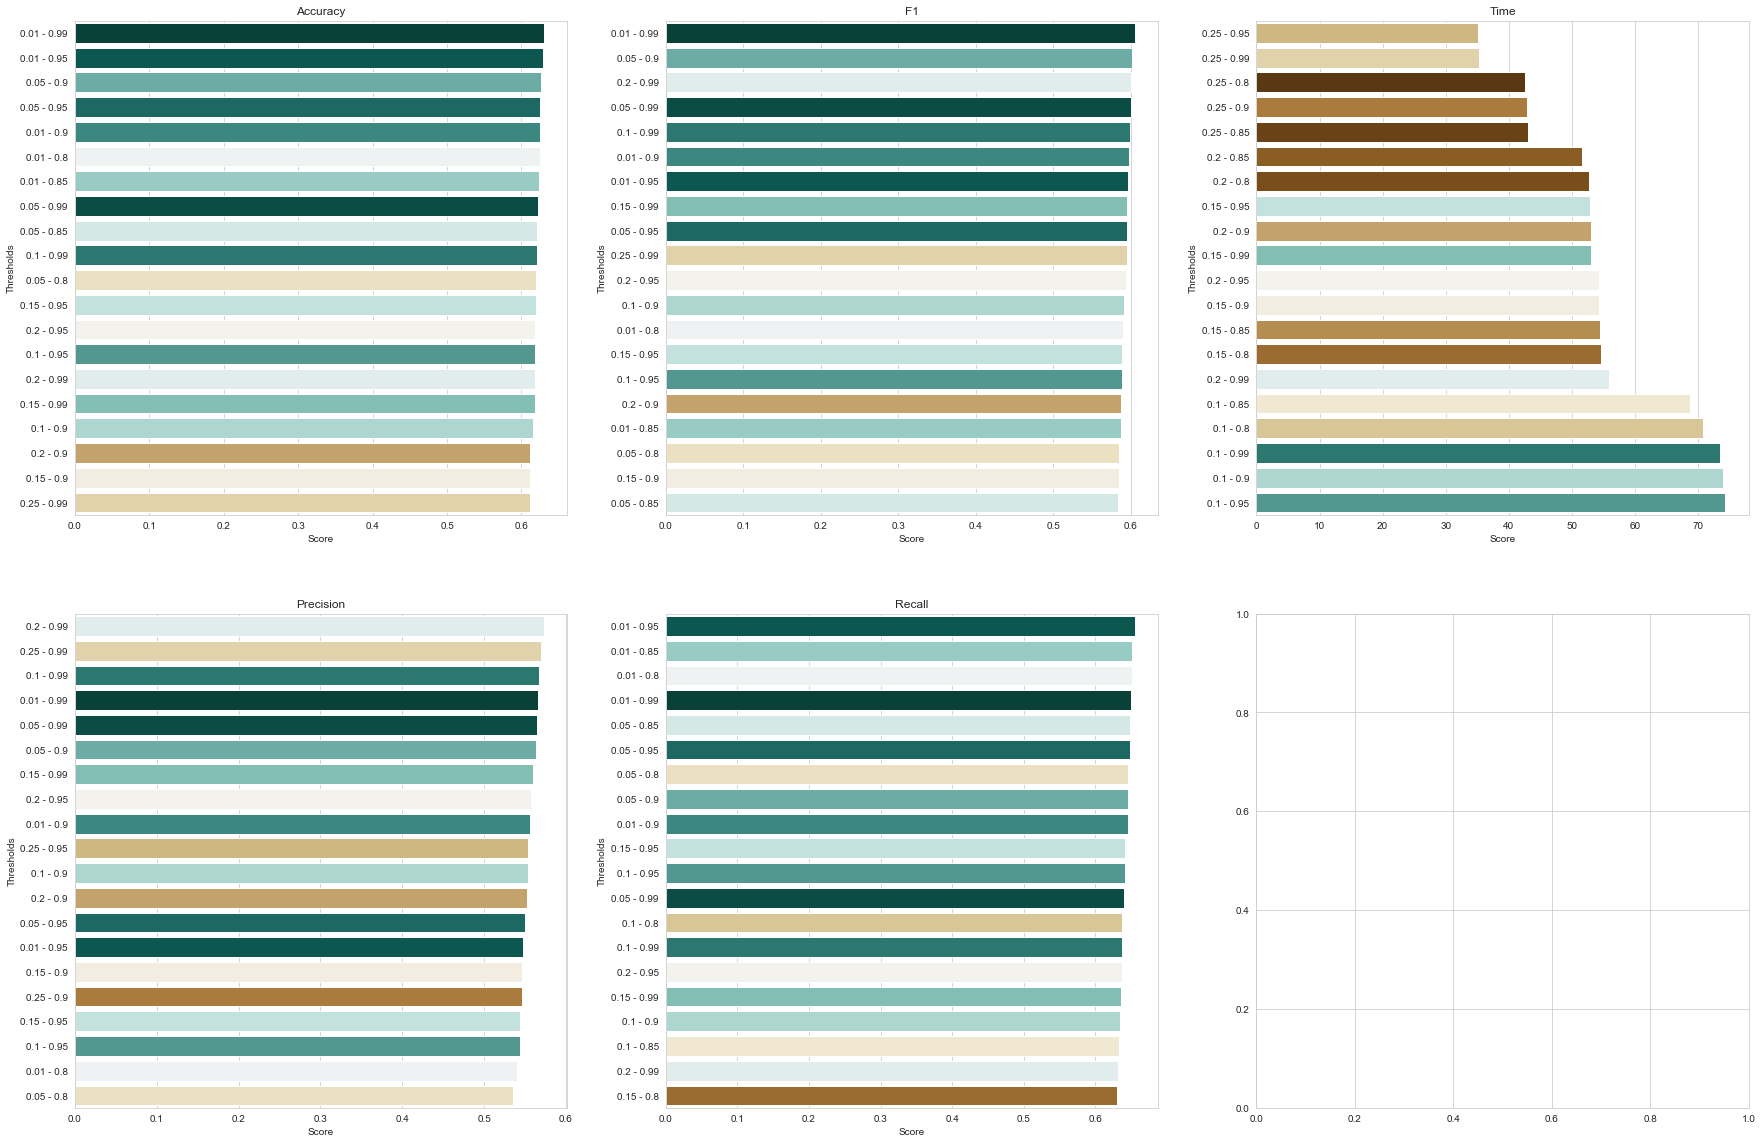

In [116]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("whitegrid")

def top_scores(scores, metrics=['Accuracy', 'F1','Precision', 'Recall', 'Time'], top=5):
    metrics_top_scores = {}
    for metric in metrics:
        metrics_top_scores[metric] = {}
        for t in range(top):

            if metric == 'Time':
                row = scores.sort_values(metric, ascending=True).reset_index().iloc[t]
            else:
                row = scores.sort_values(metric, ascending=False).reset_index().iloc[t]
                
                
            thresholds = f"{row['threshold_frecuency_low']} - {row['threshold_frecuency_high']}"
            score = row[metric]
            metrics_top_scores[metric][thresholds] = score
    return metrics_top_scores

ts = top_scores(results_df, top=20)


grid = list(build_grid(grid_ranges))
def index_in_grid(label, grid):
    # sort grid by frequencies:
    s = sorted(grid, key=lambda e: e['threshold_frecuency_high'] - e['threshold_frecuency_low'])
    for i, p in enumerate(s):
        threshold = f"{p['threshold_frecuency_low']} - {p['threshold_frecuency_high']}"
        if threshold == label:
            return i
        
def label_to_color(label, grid):
    index = index_in_grid(label, grid)
    return sns.color_palette("BrBG", 30)[index]


dfs = {
    k1: pd.DataFrame(
        data={
            'Thresholds': [k for k,_ in v1.items()], 
            'Score': [v for _,v in v1.items()],
            'Color': [label_to_color(k, grid) for k,_ in v1.items()]
        }
    ) for k1, v1 in ts.items()}


# Plot
fig, axes = plt.subplots(2, 3, figsize=(30,20))
sns.barplot(x='Score', y='Thresholds', data=dfs['Accuracy'], ax=axes[0, 0], palette=dfs['Accuracy']['Color'].values)
axes[0, 0].set_title("Accuracy")
sns.barplot(x='Score', y='Thresholds', data=dfs['F1'], ax=axes[0, 1],  palette=dfs['F1']['Color'].values)
axes[0, 1].set_title("F1")
sns.barplot(x='Score', y='Thresholds', data=dfs['Precision'], ax=axes[1, 0],  palette=dfs['Precision']['Color'].values)
axes[1, 0].set_title("Precision")
sns.barplot(x='Score', y='Thresholds', data=dfs['Recall'], ax=axes[1, 1],  palette=dfs['Recall']['Color'].values)
axes[1, 1].set_title("Recall")
sns.barplot(x='Score', y='Thresholds', data=dfs['Time'], ax=axes[0, 2],  palette=dfs['Time']['Color'].values)
axes[0, 2].set_title("Time")
plt.show()
        

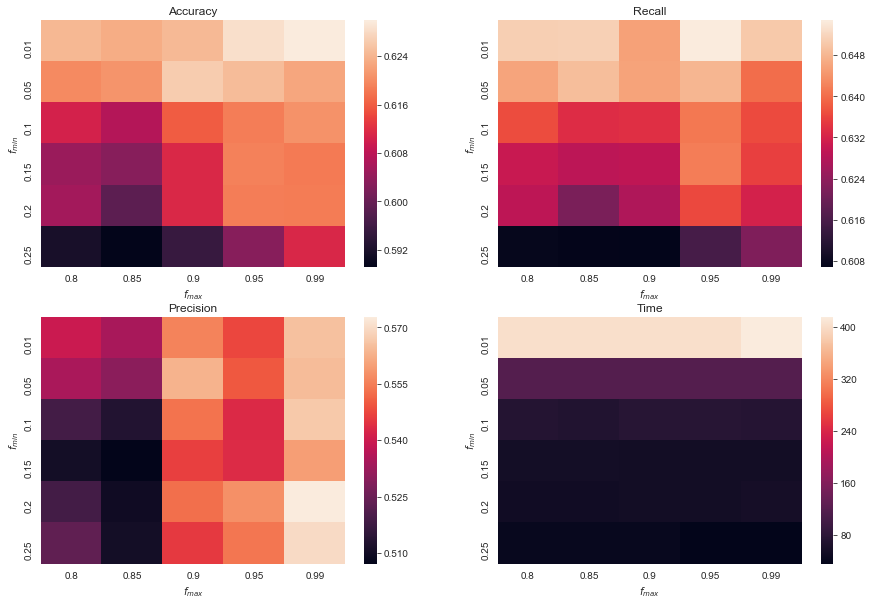

In [149]:
# Heatmap
fig, axes = plt.subplots(2, 2, figsize=(15,10))
# Accuracy
v = results_df.pivot(index='threshold_frecuency_low', columns='threshold_frecuency_high', values='Accuracy')
sns.heatmap(v, ax=axes[0, 0])
axes[0, 0].set_xlabel(r'$f_{max}$')
axes[0, 0].set_ylabel(r'$f_{min}$')
axes[0, 0].set_title("Accuracy")

# Precision
v = results_df.pivot(index='threshold_frecuency_low', columns='threshold_frecuency_high', values='Precision')
sns.heatmap(v, ax=axes[1, 0])
axes[1, 0].set_xlabel(r'$f_{max}$')
axes[1, 0].set_ylabel(r'$f_{min}$')
axes[1, 0].set_title("Precision")

# Recall
v = results_df.pivot(index='threshold_frecuency_low', columns='threshold_frecuency_high', values='Recall')
sns.heatmap(v, ax=axes[0, 1])
axes[0, 1].set_xlabel(r'$f_{max}$')
axes[0, 1].set_ylabel(r'$f_{min}$')
axes[0, 1].set_title("Recall")

# Time
v = results_df.pivot(index='threshold_frecuency_low', columns='threshold_frecuency_high', values='Time')
sns.heatmap(v, ax=axes[1, 1])
axes[1, 1].set_xlabel(r'$f_{max}$')
axes[1, 1].set_ylabel(r'$f_{min}$')
axes[1, 1].set_title("Time")

plt.show()